## Generate Historical Averages
A critical aspect of any visualization will be the comparison of the current snowpack to historical averages. The MWAC has 55 years of data so it will be a robust historical average!

### Step 1: Data Preparation
Here are the data pre-processing steps that will be performed in the following code block:
1. Replace missing values with 0
2. Create a 'Winter' identifier (e.g. 2023-2024) 
3. Create a 'Day of Winter' identifier (Day 1 is November 1st); this is required for downstream data visualizations. 

**Note:** The `hermit_lake_snowdepth.csv` is a manually curated data file that currently (as of 1/24/2024) has approximately 8 winters worth of snowpack data. 

In [1]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv("data/hermit_lake_snowdepth.csv")

# fill missing values with NA
df = df.fillna(0) # replace missing values with 0

# extract day, month, and year from date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['month_day'] = df['month'].astype(str) + '-' + df['day'].astype(str)

# function to ascertain winter (eg 2023-2024)
def get_winter(X):
    winter_list = []
    
    # loop over all rows in dataframe
    for index, row in X.iterrows():     
        
        # if month is july - december generate '{year}-{year+1}'
        if row['month'] > 6:
            winter_list.append(str(row['year']) + '-' + str(row['year']+1))
        
        # if month is january - june generate '{year-1}-{year}'
        else:
            winter_list.append(str(row['year']-1) + '-' + str(row['year']))

    return winter_list

df['winter'] = get_winter(df)


# function to assign the Nth day of winter (required for visualization)
def assign_day(date_series):
    # Convert the series of date strings to datetime objects
    date_series = pd.to_datetime(date_series, errors='coerce')
    
    # Create a reference date for November 1st of each year
    reference_dates = date_series.apply(lambda date: pd.Timestamp(date.year, 11, 1))
    
    # Calculate the number of days between each date and the corresponding reference date
    days_difference = (date_series - reference_dates).dt.days + 1
    
    # If the result is negative, consider it as days remaining in the previous year
    days_difference[days_difference < 1] += 365
    
    return days_difference
    

df['day_of_winter'] = assign_day(df['date'])


# save a CSV with the enriched snowdepth 
df.to_csv("data/cleaned_hermit_lake_snowdepth.csv")

### Step 2: Generate historical averages

Now we'll group the entire historical snowpack data by the 'day of winter' and create an average using the mean() function from Pandas. 

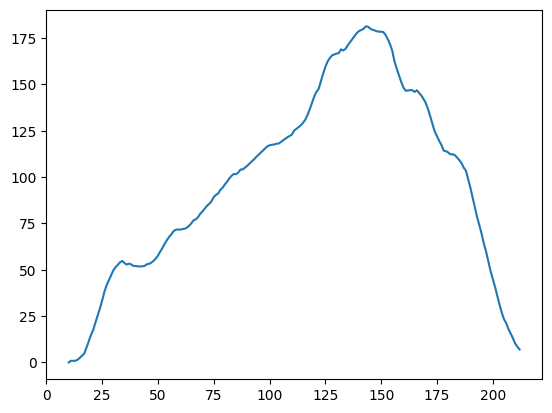

In [2]:
import matplotlib.pyplot as plt 


historical_averages = df.loc[df.winter!='2023-2024',].groupby('day_of_winter')['depth_cm'].mean().reset_index()
historical_averages = historical_averages.sort_values(['day_of_winter'])
historical_averages['depth_cm'] = (historical_averages['depth_cm'].rolling(10).sum()/10)

# visualize the data
plt.plot(historical_averages.day_of_winter,historical_averages.depth_cm)
plt.show()

# save a CSV with the historical averages (grouped by day of winter)
historical_averages.to_csv("data/historical_averages.csv")

### Step 3: Visualize this winter's snowpack in relation to historical averages

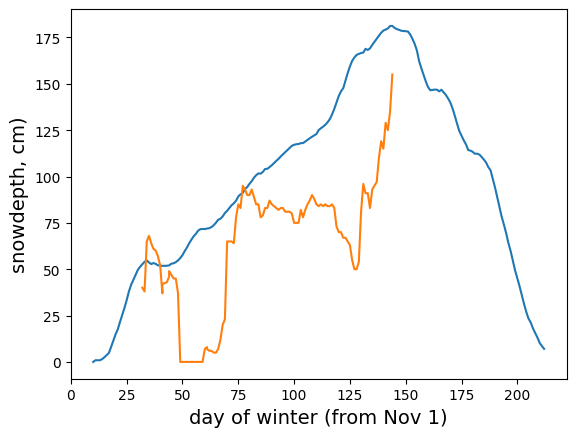

In [5]:
this_winter = df.loc[df.winter=='2023-2024',['day_of_winter', 'depth_cm']]

# visualize the data
plt.plot(historical_averages.day_of_winter,historical_averages.depth_cm)
plt.plot(this_winter.day_of_winter,this_winter.depth_cm)
plt.xlabel('day of winter (from Nov 1)', fontsize=14)
plt.ylabel('snowdepth, cm)', fontsize=14)

plt.show()

### Step 4: Calculate summary statistics

In [22]:
df.loc[df.winter == '2023-2024',]['day_of_winter'].max()

126

<Axes: xlabel='winter'>

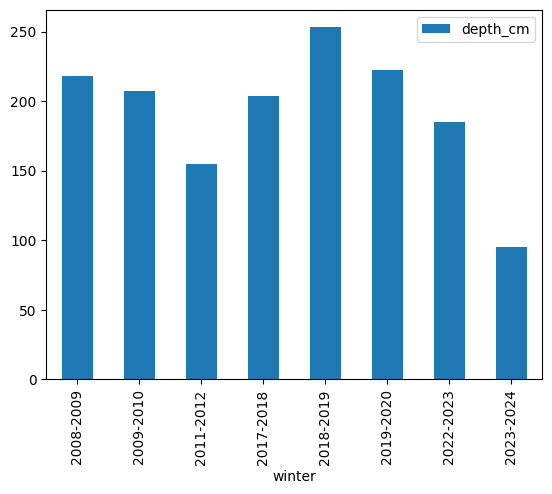

In [19]:
barchart_df = df.loc[df.winter != '2020-2021',].groupby('winter')['depth_cm'].max().reset_index()
barchart_df.plot.bar(x='winter', y='depth_cm')